In [2]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU, DCRNN, GConvLSTM

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

import matplotlib.pyplot as plt
import os

FILE_NAME='/Users/scini/Documents/GitHub/Initiator_Cell_GNN_Development/Attempts_with_Calcium/ca_data_pygt_dataset.pt'
dataset = torch.load(FILE_NAME)



/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_8319/1039459009.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(FILE_NAME)


In [3]:

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

# Visualize training and testing split
print("Number of training snapshots: {}".format(train_dataset.snapshot_count))
print("Number of testing snapshots: {}".format(test_dataset.snapshot_count))


class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h
        
model = RecurrentGCN(node_features = 1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()

mse_per_epoch = []

for epoch in tqdm(range(100)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat - snapshot.y) ** 2)
        if torch.isnan(cost):
            print("Skipping NaN snapshot at time {}".format(time))
            continue
    cost = cost / (time + 1)
    mse_per_epoch.append(cost.item())  # Store cost at each iteration
    # print("Epoch {:03d} | Train Cost: {:.4f}".format(epoch, cost.item()))
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

print("Final train cost: {:.4f}".format(cost.item()))

    


Number of training snapshots: 2880
Number of testing snapshots: 720


100%|██████████| 100/100 [03:26<00:00,  2.06s/it]

Final train cost: 0.0013


In [4]:


class RecurrentGCN2(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN2, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h
    
model2 = RecurrentGCN2(node_features = 1)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

model2.train()
mse_per_epoch2= []

for epoch in tqdm(range(100)):
    cost2 = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat2 = model2(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost2 = cost2 + torch.mean((y_hat2 - snapshot.y) ** 2)
    cost2 = cost2 / (time + 1)
    mse_per_epoch2.append(cost2.item())  # Store cost at each iteration
    cost2.backward()
    optimizer2.step()
    optimizer2.zero_grad()

print("Final train cost: {:.4f}".format(cost2.item()))


100%|██████████| 100/100 [03:16<00:00,  1.97s/it]

Final train cost: 0.0012


In [7]:
import time
# Save the models for later use
# Make a timestamp for today's date
time_stamp = time.strftime("%Y%m%d")

torch.save(model.state_dict(), f'recurrent_gcn_model_{time_stamp}.pth')
torch.save(model2.state_dict(), f'recurrent_gcn2_model_{time_stamp}.pth')

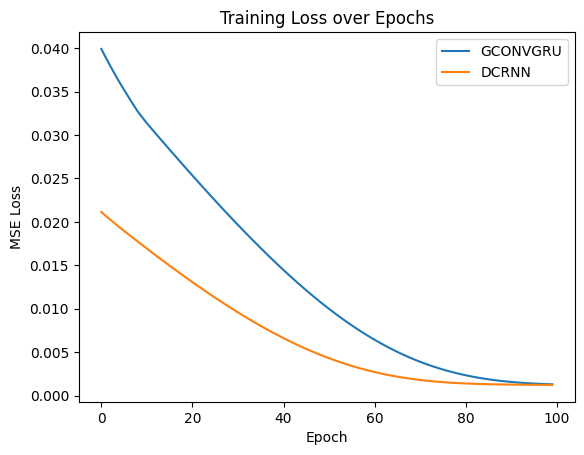

In [8]:
# Import matplotlib for visualization
import matplotlib.pyplot as plt
# Plot training loss
plt.plot(mse_per_epoch, label='GCONVGRU')
plt.plot(mse_per_epoch2, label='DCRNN')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [9]:
# Evaluate the model on the test dataset - GCONVGRU
model.eval()
cost = 0
cost_per_time = []
len_test = test_dataset.snapshot_count - 1
print("Number of snapshots in test dataset: {}".format(len_test))
for time, snapshot in enumerate(test_dataset[0:len_test]):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost_per_time.append(torch.mean((y_hat - snapshot.y) ** 2).item())  # Store cost at each iteration
    # print("Time {:03d} | Test Cost: {:.4f}".format(time, cost_per_time[-1]))
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

# Evaluate the model on the test dataset - DCRNN
model2.eval()
cost2 = 0
cost_per_time2 = []
len_test2 = test_dataset.snapshot_count - 1
print("Number of snapshots in test dataset: {}".format(len_test2))
for time, snapshot in enumerate(test_dataset[0:len_test2]):
    y_hat2 = model2(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost_per_time2.append(torch.mean((y_hat2 - snapshot.y) ** 2).item())  # Store cost at each iteration
    # print("Time {:03d} | Test Cost: {:.4f}".format(time, cost_per_time2[-1]))
    cost2 = cost2 + torch.mean((y_hat2-snapshot.y)**2)
cost2 = cost2 / (time+1)
cost2 = cost2.item()
print("MSE: {:.4f}".format(cost2))


Number of snapshots in test dataset: 719
MSE: 0.0023
Number of snapshots in test dataset: 719
MSE: 0.0021


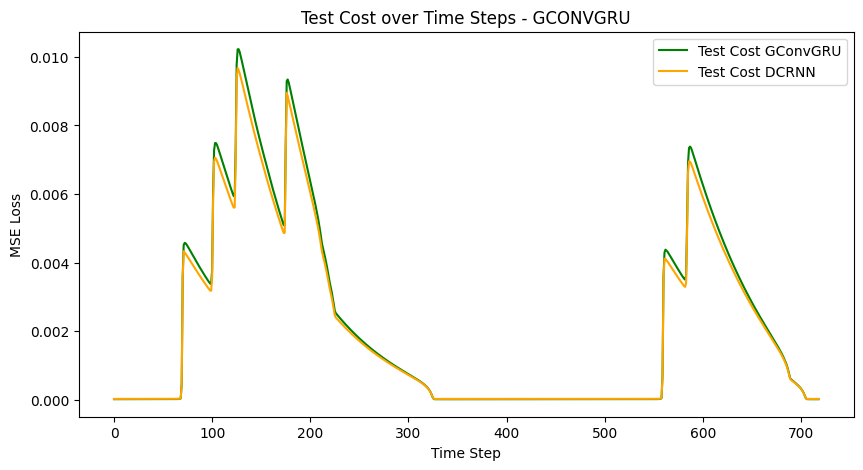

In [10]:
# Plot cost over time for test dataset
plt.figure(figsize=(10,5))
plt.plot(cost_per_time, label='Test Cost GConvGRU', color='green')
plt.plot(cost_per_time2, label='Test Cost DCRNN', color='orange')
plt.xlabel('Time Step')
plt.ylabel('MSE Loss')
plt.title('Test Cost over Time Steps - GCONVGRU')
plt.legend()

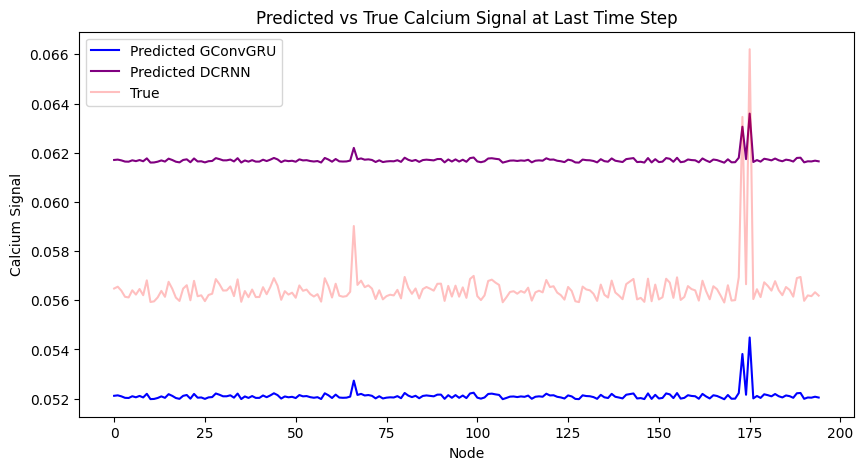

In [11]:
# Plot snapshot of predictions vs true values for the last time step
plt.figure(figsize=(10,5))
plt.plot(y_hat.detach().numpy(), label='Predicted GConvGRU', color='blue')
plt.plot(y_hat2.detach().numpy(), label='Predicted DCRNN', color='purple')
plt.plot(snapshot.y.detach().numpy(), label='True', color='red', alpha=0.25)
plt.xlabel('Node')
plt.ylabel('Calcium Signal')
plt.title('Predicted vs True Calcium Signal at Last Time Step')
plt.legend()
plt.show()

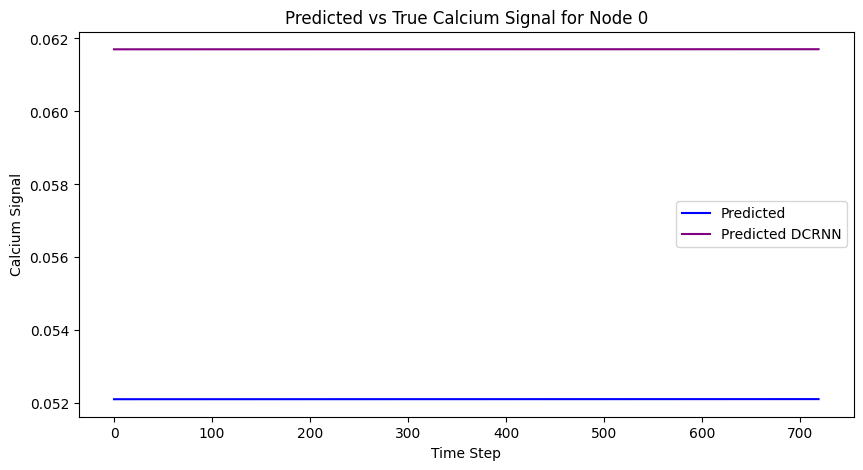

In [12]:
node_id = 0  # Change this to visualize different nodes
# Plot time series for a specific node

model.eval()
model2.eval()
predictions = []
predictions2 = []
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    y_hat2 = model2(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    predictions.append(y_hat[node_id].item())
    predictions2.append(y_hat2[node_id].item())

predictions = torch.tensor(predictions)
predictions2 = torch.tensor(predictions2)
# true_values = torch.tensor([snapshot.y[node_id].item() for snapshot in test_dataset])

plt.figure(figsize=(10,5))
plt.plot(predictions.numpy(), label='Predicted', color='blue')
plt.plot(predictions2.numpy(), label='Predicted DCRNN', color='purple')
# plt.plot(true_values.numpy(), label='True', color='red', alpha=0.25)
plt.xlabel('Time Step')
plt.ylabel('Calcium Signal')
plt.title(f'Predicted vs True Calcium Signal for Node {node_id}')
plt.legend()
plt.show()

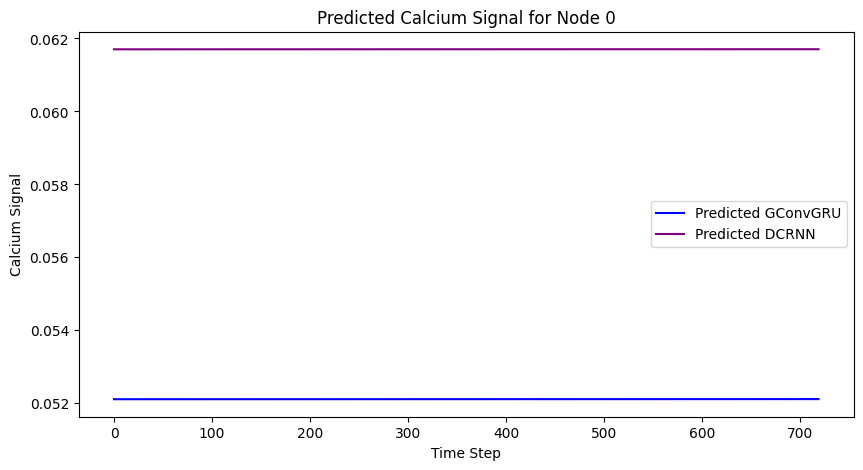

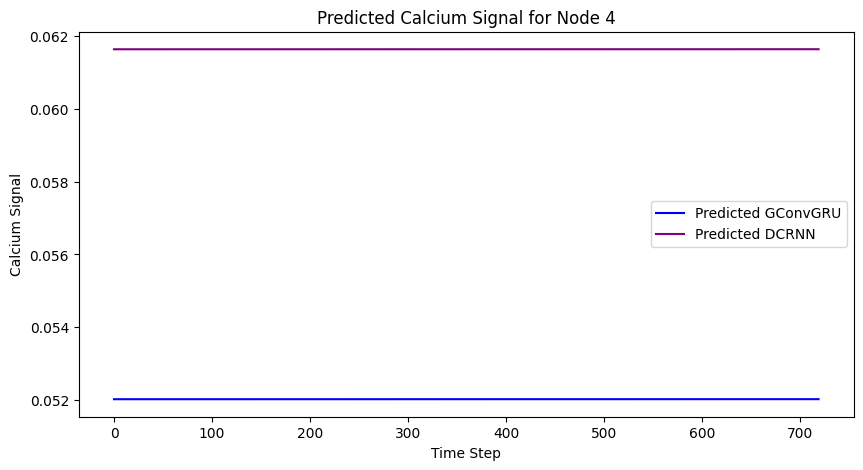

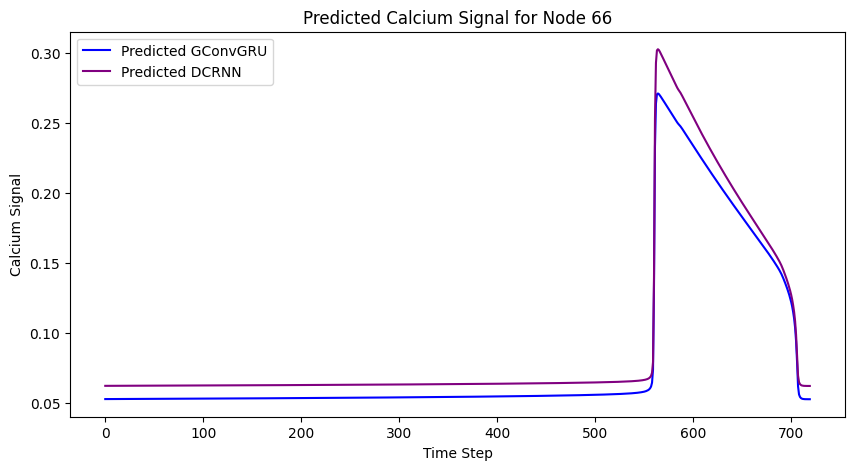

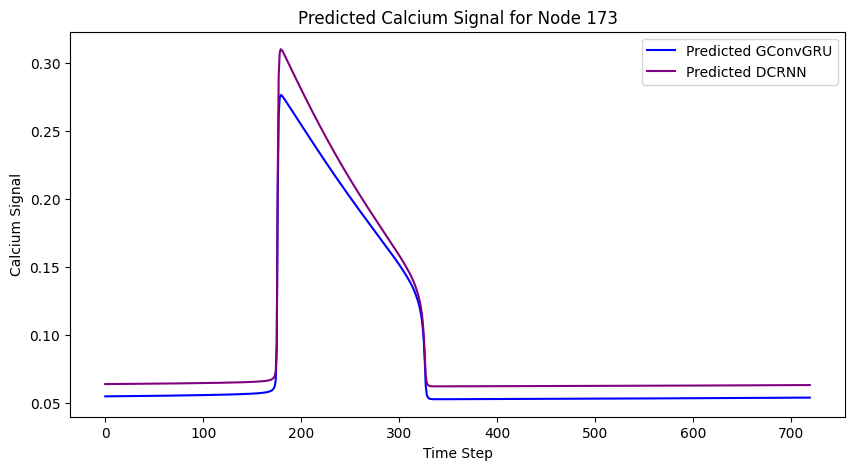

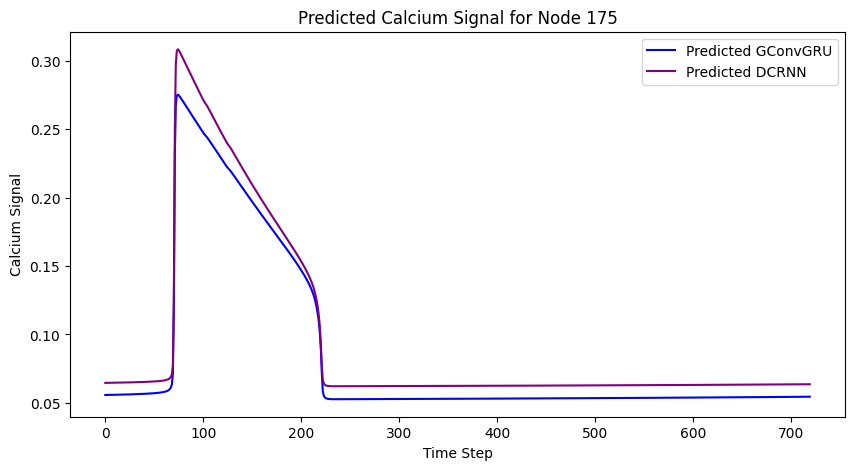

In [13]:
node_ids = [0, 4, 66, 173, 175]

for node_id in node_ids:
    # Plot time series for a specific
    model.eval()
    model2.eval()
    predictions = []
    predictions2 = []
    for time, snapshot in enumerate(test_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        y_hat2 = model2(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        predictions.append(y_hat[node_id])
        predictions2.append(y_hat2[node_id])
        # true_values.append(snapshot.y[node_id])

    # convert to numpy arrays for plotting
    predictions = torch.stack(predictions).detach().cpu().numpy()
    predictions2 = torch.stack(predictions2).detach().cpu().numpy()
    # true_values = torch.stack(true_values).detach().cpu().numpy()
    plt.figure(figsize=(10,5))
    plt.plot(predictions, label='Predicted GConvGRU', color='blue')
    plt.plot(predictions2, label='Predicted DCRNN', color='purple')
    # plt.plot(true_values.numpy(), label='True', color='red', alpha=0.25)
    plt.xlabel('Time Step')
    plt.ylabel('Calcium Signal')
    plt.title(f'Predicted Calcium Signal for Node {node_id}')
    plt.legend()
    plt.show()


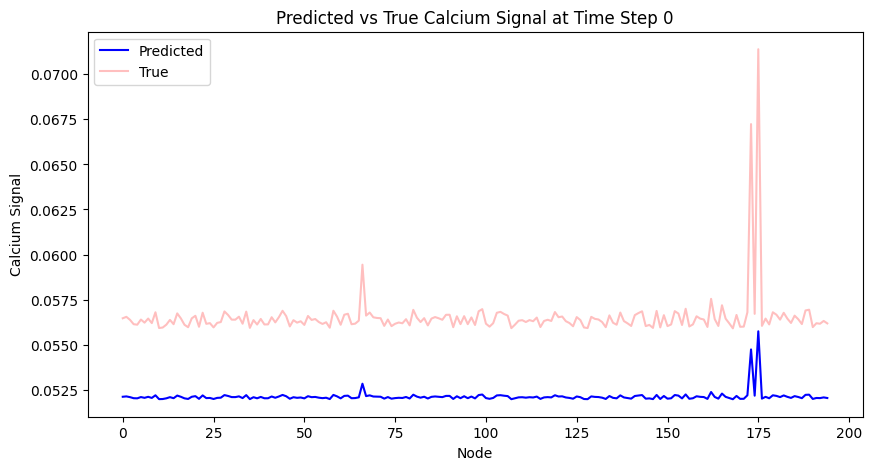

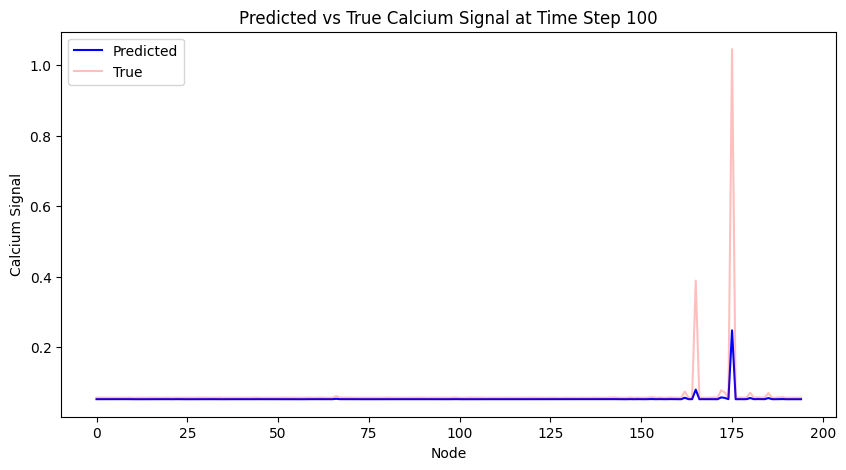

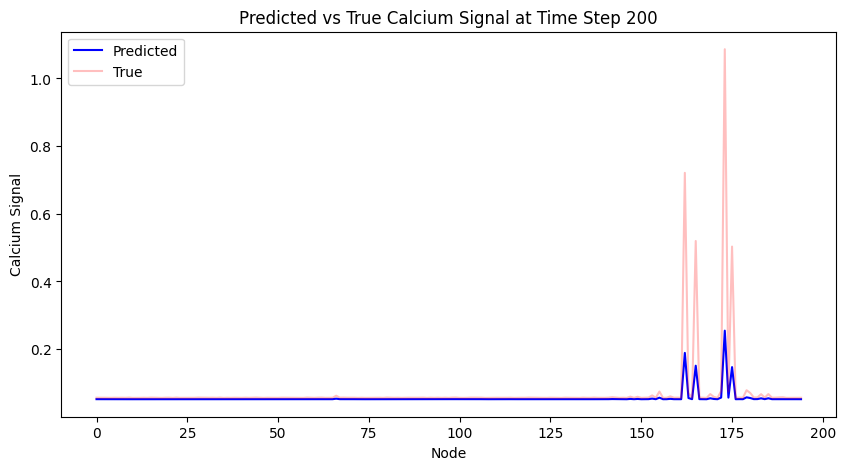

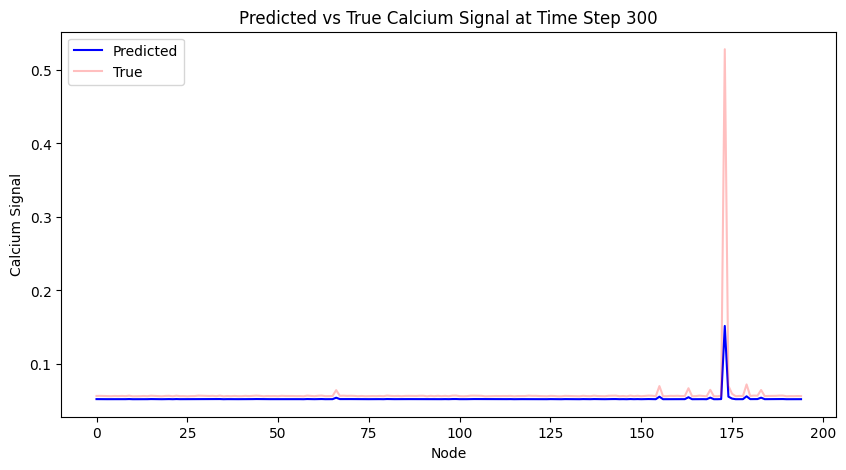

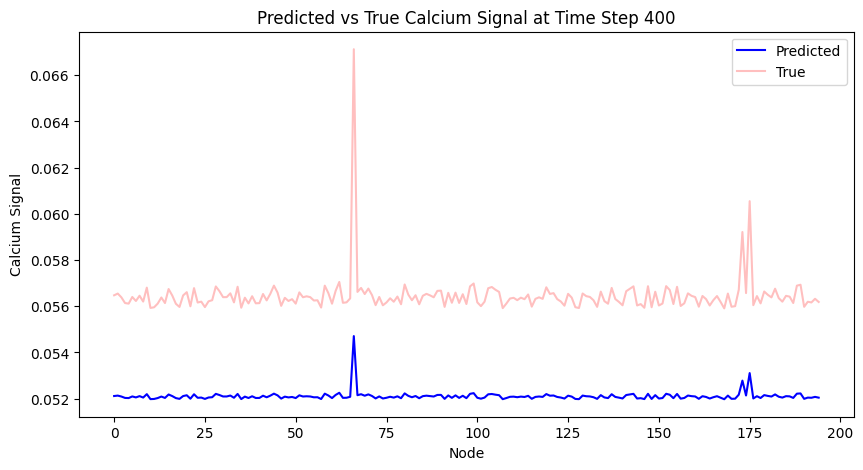

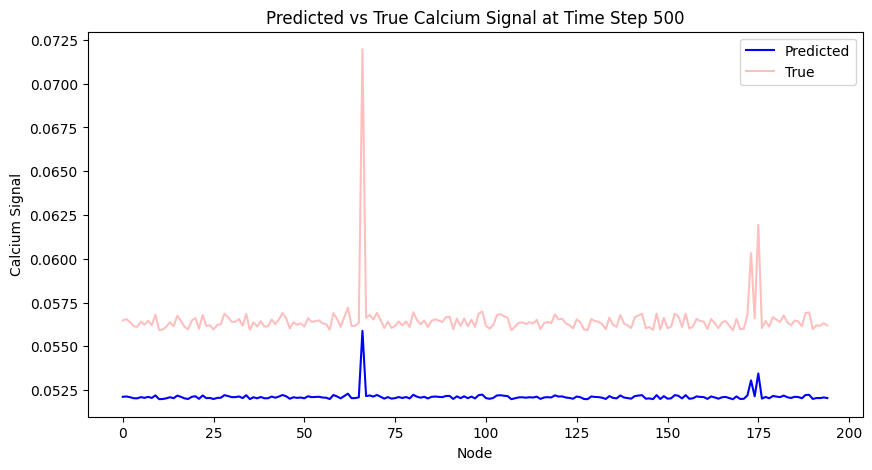

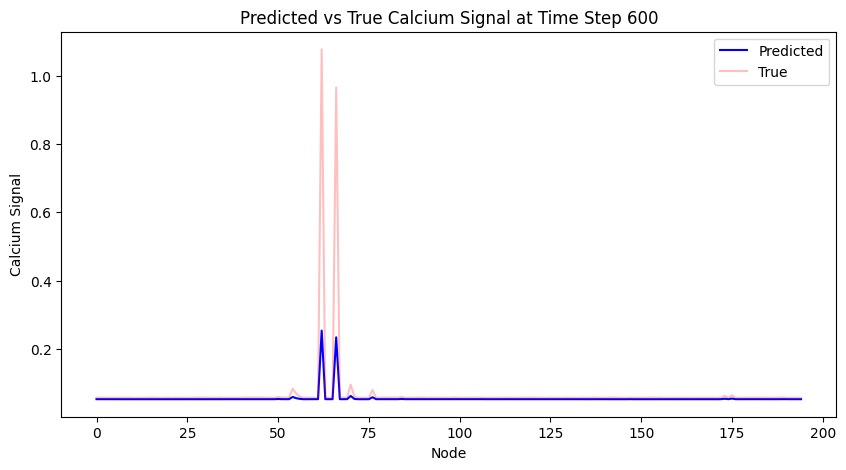

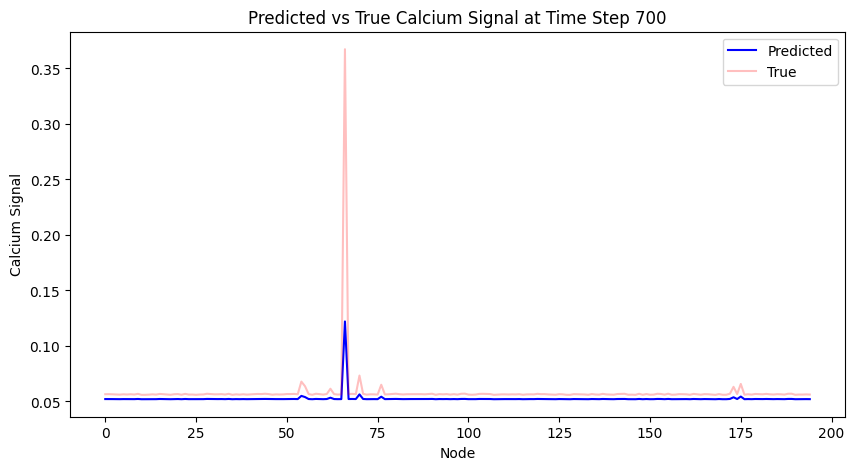

In [14]:
for time, snapshot in enumerate(test_dataset[0:len_test-1]):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    if time % 100 != 0:
        continue
    # Plot snapshot of predictions vs true values for each time step
    plt.figure(figsize=(10,5))
    plt.plot(y_hat.detach().numpy(), label='Predicted', color='blue')
    plt.plot(snapshot.y.detach().numpy(), label='True', color='red', alpha=0.25)
    plt.xlabel('Node')
    plt.ylabel('Calcium Signal')
    plt.title('Predicted vs True Calcium Signal at Time Step {}'.format(time))
    plt.legend()
    plt.show()
    

## Evaluate against other traces

/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_8319/2998045455.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_test_dataset1 = torch.load(TEST1_FILENAME)

Number of snapshots in test dataset: 358
MSE: 0.0012
Number of snapshots in test dataset: 358
MSE: 0.0012


Text(0.5, 1.0, 'Test Cost over Time Steps - GCONVGRU')

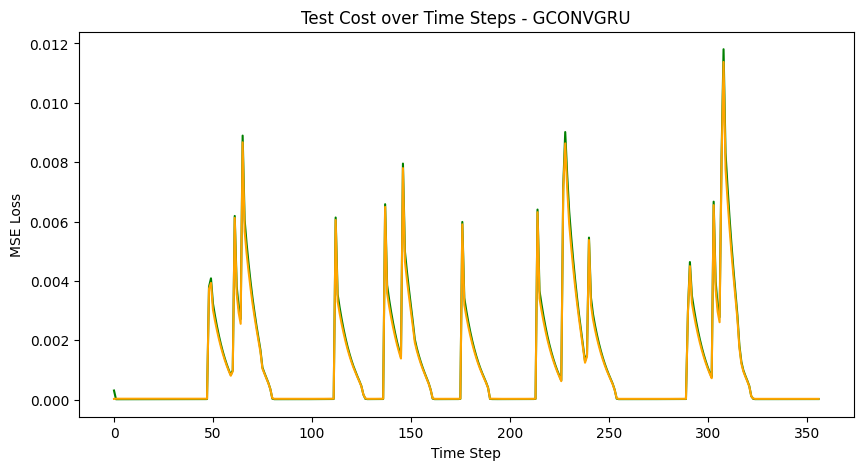

In [15]:
TEST1_FILENAME = '/Users/scini/Documents/GitHub/Initiator_Cell_GNN_Development/Attempts_with_Calcium/ca_data_pygt_dataset_s528491_20251030102201.pt'
new_test_dataset1 = torch.load(TEST1_FILENAME)

# Evaluate the model on the test dataset - GCONVGRU
model.eval()
cost = 0
cost_per_time = []
len_test1 = new_test_dataset1.snapshot_count - 1
print("Number of snapshots in test dataset: {}".format(len_test1))
for time, snapshot in enumerate(new_test_dataset1[0:len_test1 - 1]):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost_per_time.append(torch.mean((y_hat - snapshot.y) ** 2).item())  # Store cost at each iteration
    # print("Time {:03d} | Test Cost: {:.4f}".format(time, cost_per_time[-1]))
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

# Evaluate the model on the test dataset - DCRNN
model2.eval()
cost2 = 0
cost_per_time2 = []
print("Number of snapshots in test dataset: {}".format(len_test1))
for time, snapshot in enumerate(new_test_dataset1[0:len_test1 - 1]):
    y_hat2 = model2(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost_per_time2.append(torch.mean((y_hat2 - snapshot.y) ** 2).item())  # Store cost at each iteration
    # print("Time {:03d} | Test Cost: {:.4f}".format(time, cost_per_time2[-1]))
    cost2 = cost2 + torch.mean((y_hat2-snapshot.y)**2)
cost2 = cost2 / (time+1)
cost2 = cost2.item()
print("MSE: {:.4f}".format(cost2))

# Plot cost over time for test dataset
plt.figure(figsize=(10,5))
plt.plot(cost_per_time, label='Test Cost GConvGRU', color='green')
plt.plot(cost_per_time2, label='Test Cost DCRNN', color='orange')
plt.xlabel('Time Step')
plt.ylabel('MSE Loss')
plt.title('Test Cost over Time Steps - GCONVGRU')
    



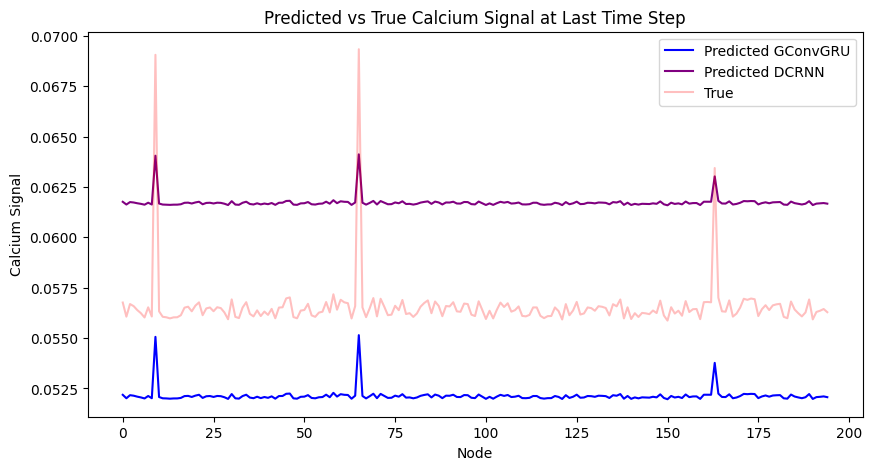

In [16]:
# Plot snapshot of predictions vs true values for the last time step
plt.figure(figsize=(10,5))
plt.plot(y_hat.detach().numpy(), label='Predicted GConvGRU', color='blue')
plt.plot(y_hat2.detach().numpy(), label='Predicted DCRNN', color
='purple')
plt.plot(snapshot.y.detach().numpy(), label='True', color='red', alpha=0.25)
plt.xlabel('Node')
plt.ylabel('Calcium Signal')
plt.title('Predicted vs True Calcium Signal at Last Time Step')
plt.legend()
plt.show()

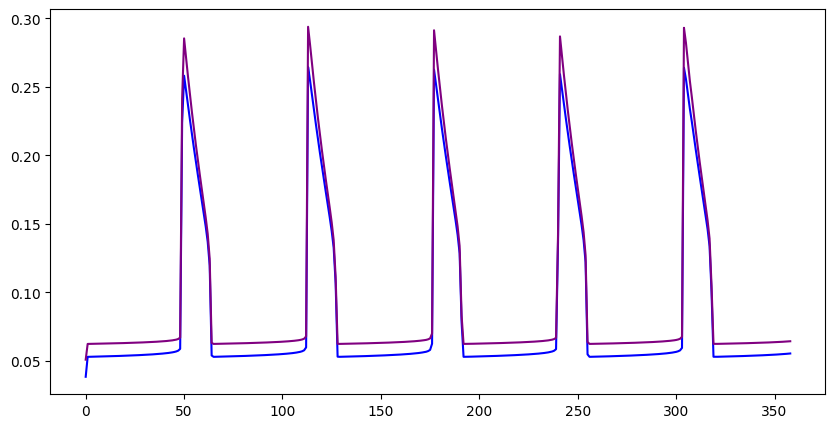

In [17]:
# Plot at every 20th time step for node 0
node_id = 9  # Change this to visualize different nodes
# Plot time series for a specific node
model.eval()
model2.eval()
predictions = []
predictions2 = []
for time, snapshot in enumerate(new_test_dataset1):
    # if time % 20 == 0:
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        y_hat2 = model2(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        # true_values = torch.tensor([snapshot.y[node_id].item() for snapshot in test_dataset])
        predictions.append(y_hat[node_id])
        predictions2.append(y_hat2[node_id])

predictions = torch.stack(predictions).detach().cpu().numpy()
predictions2 = torch.stack(predictions2).detach().cpu().numpy()

plt.figure(figsize=(10,5))
plt.plot(predictions, label='Predicted GConvGRU', color='blue')
plt.plot(predictions2, label='Predicted DCRNN', color='purple')



/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_8319/2123796552.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_test_dataset1 = torch.load(TEST2_FILENAME)

Number of snapshots in test dataset: 359
MSE: 0.0060
Number of snapshots in test dataset: 359
MSE: 0.0057


Text(0.5, 1.0, 'Test Cost over Time Steps')

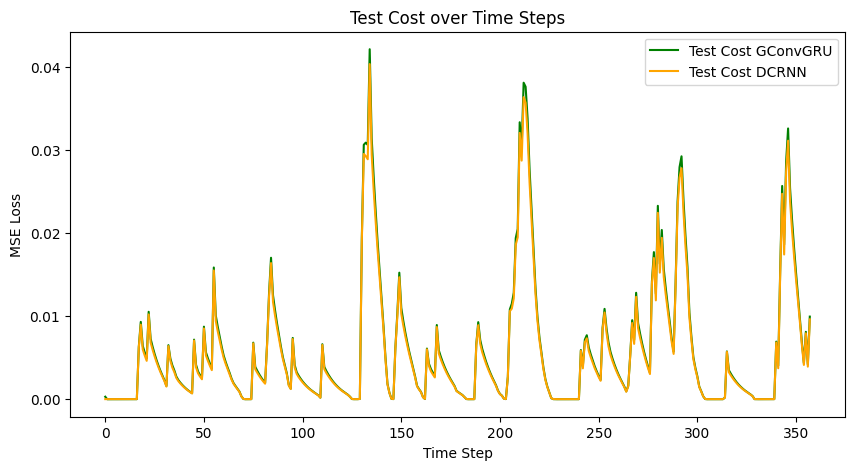

In [18]:
TEST2_FILENAME = '/Users/scini/Documents/GitHub/Initiator_Cell_GNN_Development/Attempts_with_Calcium/ca_data_pygt_dataset_s123456_10c_20251030112404.pt'
new_test_dataset1 = torch.load(TEST2_FILENAME)

# Evaluate the model on the test dataset - GCONVGRU
model.eval()
cost = 0
cost_per_time = []
len_test1 = new_test_dataset1.snapshot_count
print("Number of snapshots in test dataset: {}".format(len_test1))
for time, snapshot in enumerate(new_test_dataset1[0:len_test1 - 1]):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost_per_time.append(torch.mean((y_hat - snapshot.y) ** 2).item())  # Store cost at each iteration
    # print("Time {:03d} | Test Cost: {:.4f}".format(time, cost_per_time[-1]))
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

# Evaluate the model on the test dataset - DCRNN
model2.eval()
cost2 = 0
cost_per_time2 = []
print("Number of snapshots in test dataset: {}".format(len_test1))
for time, snapshot in enumerate(new_test_dataset1[0:len_test1 - 1]):
    y_hat2 = model2(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost_per_time2.append(torch.mean((y_hat2 - snapshot.y) ** 2).item())  # Store cost at each iteration
    # print("Time {:03d} | Test Cost: {:.4f}".format(time, cost_per_time2[-1]))
    cost2 = cost2 + torch.mean((y_hat2-snapshot.y)**2)
cost2 = cost2 / (time+1)
cost2 = cost2.item()
print("MSE: {:.4f}".format(cost2))

# Plot cost over time for test dataset
plt.figure(figsize=(10,5))
plt.plot(cost_per_time, label='Test Cost GConvGRU', color='green')
plt.plot(cost_per_time2, label='Test Cost DCRNN', color='orange')
plt.xlabel('Time Step')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Test Cost over Time Steps')
    

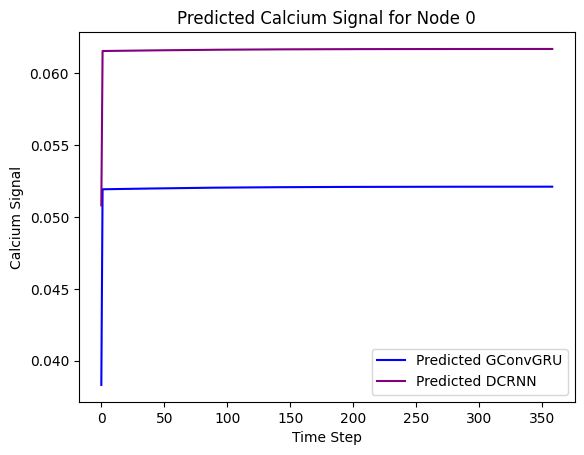

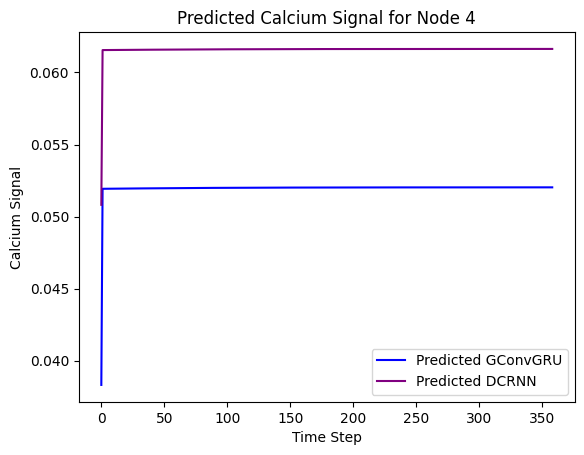

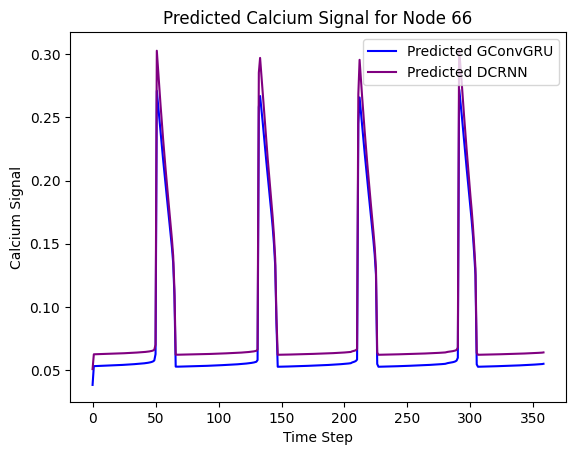

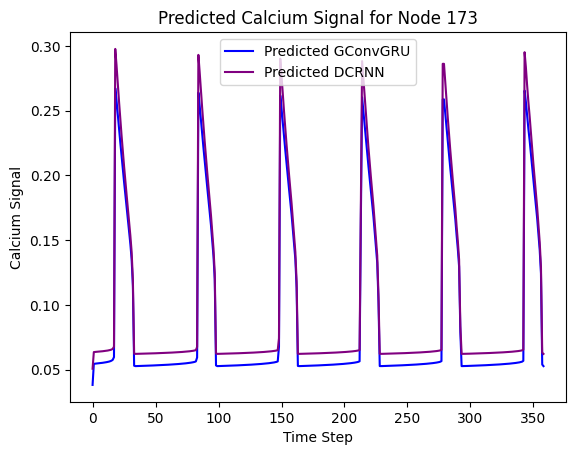

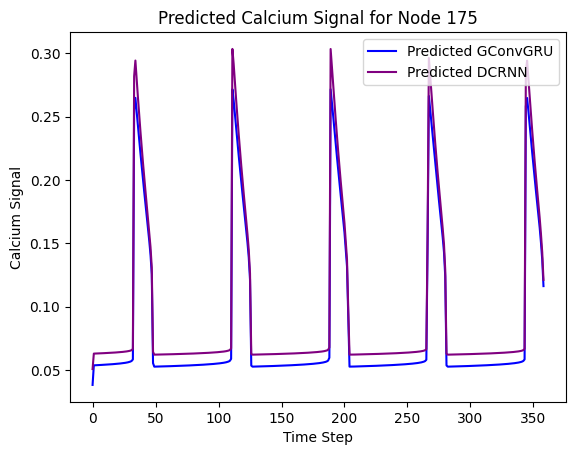

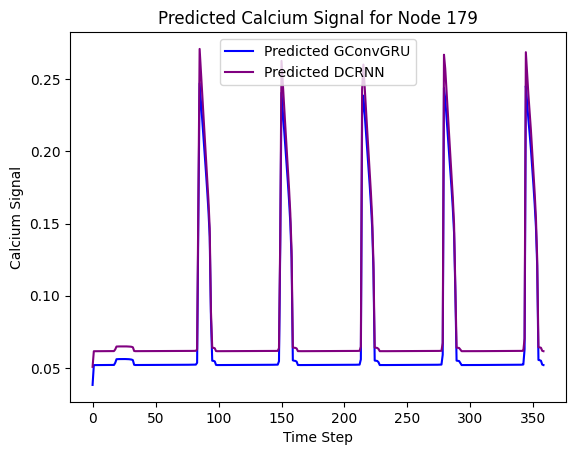

In [24]:
# Plot at every 20th time step for node 0
node_id = 179  # Change this to visualize different nodes
node_ids = [0, 4, 66, 173, 175, 179]
# Plot time series for a specific node
model.eval()
model2.eval()

for node in node_ids:
    predictions = []
    predictions2 = []
    for time, snapshot in enumerate(new_test_dataset1):
        # if time % 20 == 0:
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            y_hat2 = model2(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            # true_values = torch.tensor([snapshot.y[node_id].item() for snapshot in test_dataset])
            predictions.append(y_hat[node])
            predictions2.append(y_hat2[node])

    predictions = torch.stack(predictions).detach().cpu().numpy()
    predictions2 = torch.stack(predictions2).detach().cpu().numpy()

    # plt.figure(figsize=(10,5))
    plt.plot(predictions, label='Predicted GConvGRU', color='blue')
    plt.plot(predictions2, label='Predicted DCRNN', color='purple')
    plt.xlabel('Time Step')
    plt.ylabel('Calcium Signal')
    plt.title(f'Predicted Calcium Signal for Node {node}')
    plt.legend()
    plt.show()


/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_8319/3063425531.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_test_dataset1 = torch.load(TEST3_FILENAME)

Number of snapshots in test dataset: 359
MSE: 0.0066
Number of snapshots in test dataset: 359
MSE: 0.0063


Text(0.5, 1.0, 'Test Cost over Time Steps')

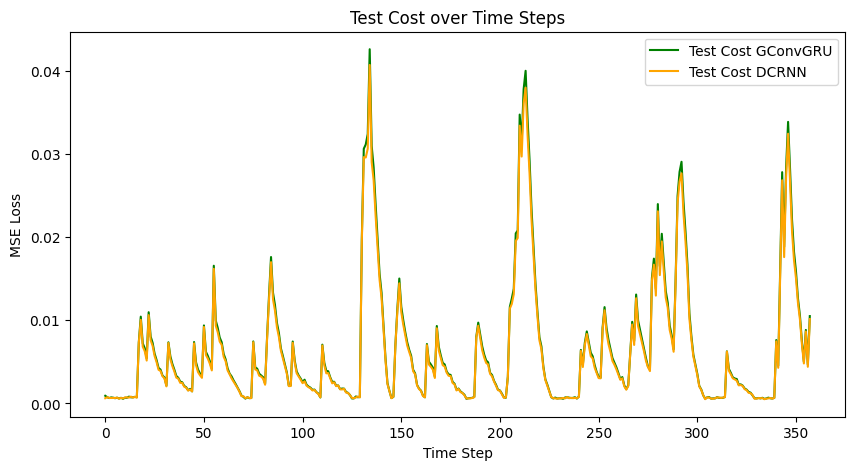

In [27]:
TEST3_FILENAME = '/Users/scini/Documents/GitHub/Initiator_Cell_GNN_Development/Attempts_with_Calcium/ca_data_pygt_dataset_s123456_10c_noisy25_20251030145641.pt'
new_test_dataset1 = torch.load(TEST3_FILENAME)

# Evaluate the model on the test dataset - GCONVGRU
model.eval()
cost = 0
cost_per_time = []
len_test1 = new_test_dataset1.snapshot_count
print("Number of snapshots in test dataset: {}".format(len_test1))
for time, snapshot in enumerate(new_test_dataset1[0:len_test1 - 1]):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost_per_time.append(torch.mean((y_hat - snapshot.y) ** 2).item())  # Store cost at each iteration
    # print("Time {:03d} | Test Cost: {:.4f}".format(time, cost_per_time[-1]))
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

# Evaluate the model on the test dataset - DCRNN
model2.eval()
cost2 = 0
cost_per_time2 = []
print("Number of snapshots in test dataset: {}".format(len_test1))
for time, snapshot in enumerate(new_test_dataset1[0:len_test1 - 1]):
    y_hat2 = model2(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost_per_time2.append(torch.mean((y_hat2 - snapshot.y) ** 2).item())  # Store cost at each iteration
    # print("Time {:03d} | Test Cost: {:.4f}".format(time, cost_per_time2[-1]))
    cost2 = cost2 + torch.mean((y_hat2-snapshot.y)**2)
cost2 = cost2 / (time+1)
cost2 = cost2.item()
print("MSE: {:.4f}".format(cost2))

# Plot cost over time for test dataset
plt.figure(figsize=(10,5))
plt.plot(cost_per_time, label='Test Cost GConvGRU', color='green')
plt.plot(cost_per_time2, label='Test Cost DCRNN', color='orange')
plt.xlabel('Time Step')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Test Cost over Time Steps')

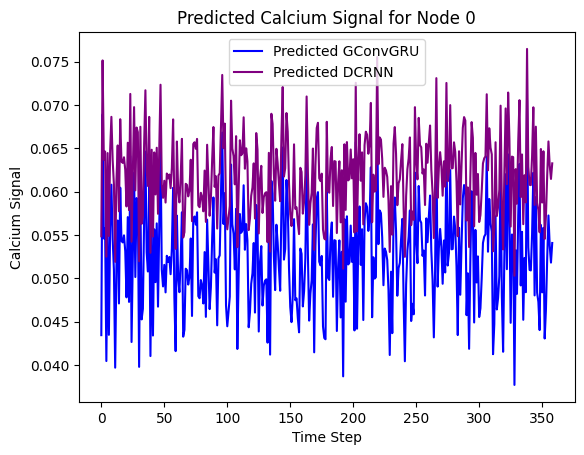

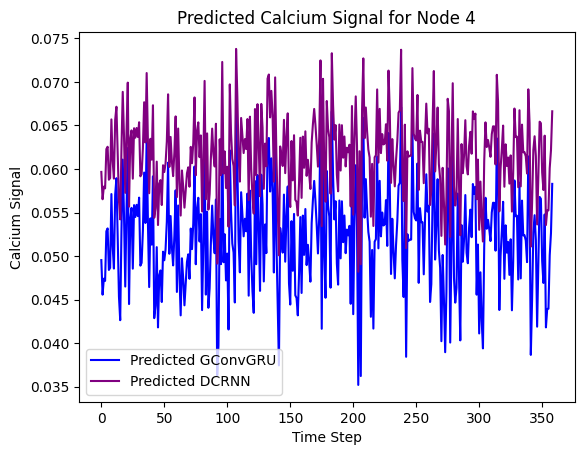

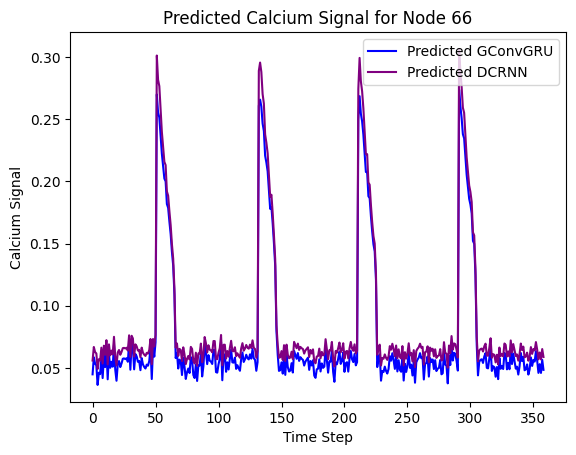

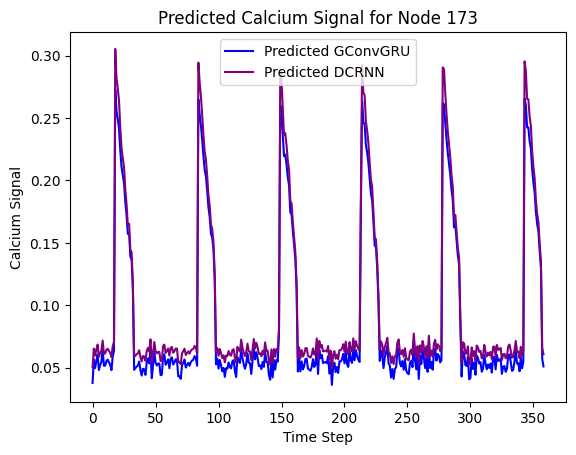

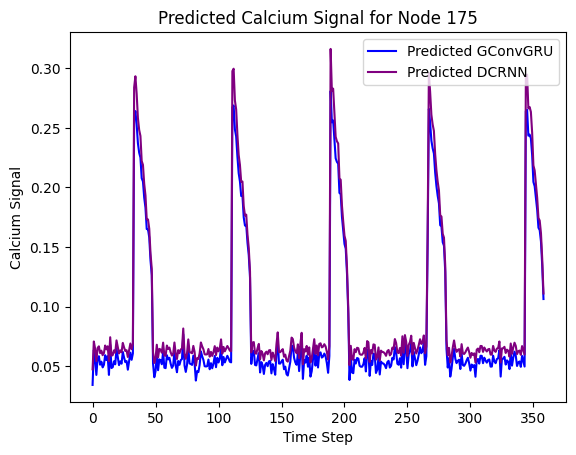

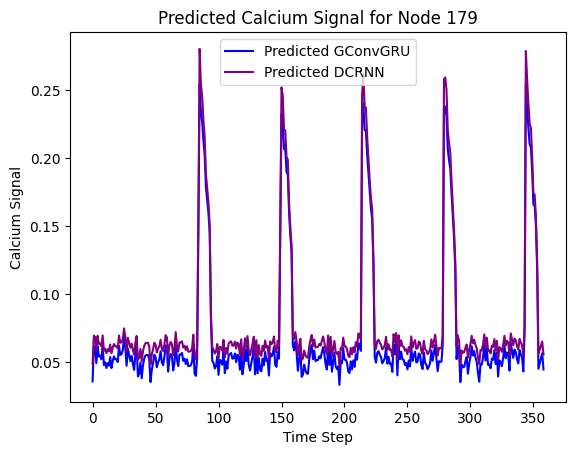

In [28]:
# Plot at every 20th time step for node 0
node_id = 179  # Change this to visualize different nodes
node_ids = [0, 4, 66, 173, 175, 179]
# Plot time series for a specific node
model.eval()
model2.eval()

for node in node_ids:
    predictions = []
    predictions2 = []
    for time, snapshot in enumerate(new_test_dataset1):
        # if time % 20 == 0:
            y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            y_hat2 = model2(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
            # true_values = torch.tensor([snapshot.y[node_id].item() for snapshot in test_dataset])
            predictions.append(y_hat[node])
            predictions2.append(y_hat2[node])

    predictions = torch.stack(predictions).detach().cpu().numpy()
    predictions2 = torch.stack(predictions2).detach().cpu().numpy()

    # plt.figure(figsize=(10,5))
    plt.plot(predictions, label='Predicted GConvGRU', color='blue')
    plt.plot(predictions2, label='Predicted DCRNN', color='purple')
    plt.xlabel('Time Step')
    plt.ylabel('Calcium Signal')
    plt.title(f'Predicted Calcium Signal for Node {node}')
    plt.legend()
    plt.show()